If you are running this notebook on Google Colab, you can mount your Google Drive to save the data and load them later. To do this, uncomment the following code and follow the instructions.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
## install the required packages. This may take a few minutes. 

%pip install medmnist
%pip install tensorflow==2.15.0
%pip install matplotlib
%pip install lime
%pip install opencv-python

In [ ]:
## import the required packages. 

import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import os
from medmnist.dataset import PneumoniaMNIST
import random
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

In [4]:
## set the seeds and enable deterministic operations for reproducibility.

os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()
kseed=0
np.random.seed(kseed)
random.seed(kseed)
tf.random.set_seed(kseed)
tf.keras.utils.set_random_seed(kseed)

In [5]:
## set the input and output directories. You can change the input directory to any directory where you want to save the data.

input_root = '/home/biosim/Fanis/ISBI'
output_root = os.path.join(input_root, 'PneumoniaMNIST')
if not os.path.isdir(output_root):
    os.makedirs(output_root)

In [6]:
## download the PneumoniaMNIST dataset and load the data.

_ = PneumoniaMNIST(split="train", root=input_root, download=True, size=224)

Using downloaded and verified file: /home/biosim/Fanis/ISBI/pneumoniamnist_224.npz


In [7]:
## split the data.

npz_file = np.load(os.path.join(input_root, "pneumoniamnist_224.npz"))

x_train = npz_file['train_images']
x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
y_train = npz_file['train_labels']

x_val = npz_file['val_images']
x_val = np.repeat(x_val[..., np.newaxis], 3, axis=-1)
y_val = npz_file['val_labels']

x_test = npz_file['test_images']
x_test = np.repeat(x_test[..., np.newaxis], 3, axis=-1)
y_test = npz_file['test_labels']

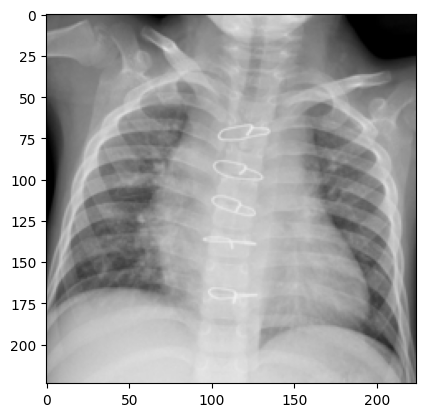

In [8]:
## display the first image in the training set.

plt.imshow(x_train[0])

In [9]:
## define a function to create a ResNet50 model.

def create_model(pooling='max', lr=0.001):
    """
    This function creates a ResNet50 model.

    Parameters:
    pooling (str): the type of global pooling to be applied, default is 'max'
    lr (float): learning rate, default is 0.001

    Returns:
    model (tf.keras.models.Model): the compiled model
    """
    tf.keras.backend.clear_session()  # Clear the backend session to free up memory and prevent slowdowns

    i = tf.keras.layers.Input([224, 224, 3], dtype="uint8")  # Define the input layer for the model, with shape (224, 224, 3) and type uint8
    x = tf.keras.layers.Lambda(lambda x: tf.cast(x, "float32"))(i)  # Cast the input data to float32 type
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input(x)  # Preprocess the input data using the ResNetV2 preprocessing function

    # Load the pretrained ResNet50V2 model, without the fully connected layers (include_top=False), with the specified pooling, pretrained on ImageNet (weights='imagenet'), and feed it with the preprocessed input
    pretrained_model = tf.keras.applications.ResNet50V2(include_top=False, pooling=pooling, weights='imagenet', input_tensor=preprocess_input)

    x = pretrained_model.output  # Get the output of the pretrained model
    x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Add a dense layer with 1024 nodes and ReLU activation
    out = tf.keras.layers.Dense(2, activation='softmax')(x)  # Add a dense output layer with 2 units (for binary classification) and softmax activation
    model = tf.keras.models.Model(i, outputs=out)  # Define the model with the specified input and output
    model.summary()  # Print a summary of the model

    # Compile the model with the Adam optimizer with the specified learning rate, the categorical crossentropy loss function, and several evaluation metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='CategoricalCrossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.AUC(curve='PR', name='auprc')]
                  )
    return model  # Return the compiled model

In [10]:
model = create_model()

2024-05-26 20:18:42.593169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-26 20:18:42.595395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-26 20:18:42.595724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)          0         ['lambda[0][0]']              
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)          0         ['tf.math.truediv[0][0]'] 

In [11]:
## train the model.

y_train_one_hot = tf.keras.utils.to_categorical(y_train) # convert the target output for training in one-hot format
y_val_one_hot = tf.keras.utils.to_categorical(y_val)
history = model.fit(x_train, y_train_one_hot, epochs=100, validation_data=(x_val, y_val_one_hot),
                    # Use the validation data for early stopping to stop training when a monitored metric has stopped improving
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                                                mode='max',
                                                                patience=30,
                                                                verbose=1,
                                                                restore_best_weights=True)]
                    )

Epoch 1/100


2024-05-17 13:27:52.907932: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-17 13:27:57.860235: I external/local_xla/xla/service/service.cc:168] XLA service 0x72b8c89474d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 13:27:57.860275: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-17 13:27:58.010516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715941678.386410  414558 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 [==============================] - 107s 241ms/step - loss: 1.0805 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9674 - auprc: 0.9600 - val_loss: 0.7250 - val_accuracy: 0.9389 - val_precision: 0.9389 - val_recall: 0.9389 - val_auc: 0.9641 - val_auprc: 0.9546
Epoch 2/100
148/148 [==============================] - 30s 204ms/step - loss: 0.1010 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9941 - auprc: 0.9936 - val_loss: 0.1221 - val_accuracy: 0.9733 - val_precision: 0.9733 - val_recall: 0.9733 - val_auc: 0.9865 - val_auprc: 0.9835
Epoch 3/100
148/148 [==============================] - 30s 206ms/step - loss: 0.0599 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9974 - auprc: 0.9972 - val_loss: 0.1234 - val_accuracy: 0.9580 - val_precision: 0.9580 - val_recall: 0.9580 - val_auc: 0.9909 - val_auprc: 0.9897
Epoch 4/100
148/148 [==============================] - 30s 201ms/step - loss: 0.0489 - accuracy: 0.9826 - precision: 0.9826

In [12]:
## save the model weights.

model.save_weights(os.path.join(input_root, 'model.weights.h5'))

In [11]:
## load the model weights.

model.load_weights(os.path.join(input_root, 'model.weights.h5'))

In [12]:
## evaluate the model.

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_labels)
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
f1 = f1_score(y_test, y_pred_labels)
confusion = confusion_matrix(y_test, y_pred_labels)

print("Confusion Matrix:")
print(confusion)

print("Accuracy: ", accuracy)
print("ROC AUC: ", roc_auc)
print("F1 Score: ", f1)

2024-05-26 20:18:50.913962: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


20/20 [==============================] - 5s 102ms/step
Confusion Matrix:
[[170  64]
 [  2 388]]
Accuracy:  0.8942307692307693
ROC AUC:  0.9796789392943239
F1 Score:  0.9216152019002375


In [13]:
## create four lists to hold the indices of the true positives, true negatives, false positives, and false negatives.

# Initialize lists to hold the indices of each category
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []

# Iterate over the test set and categorize each image
for i in range(len(y_test)):
    # True positives
    if y_test[i] == 1 and y_pred_labels[i] == 1:
        true_positives.append(i)
    # True negatives
    elif y_test[i] == 0 and y_pred_labels[i] == 0:
        true_negatives.append(i)
    # False positives
    elif y_test[i] == 0 and y_pred_labels[i] == 1:
        false_positives.append(i)
    # False negatives
    elif y_test[i] == 1 and y_pred_labels[i] == 0:
        false_negatives.append(i)

# Select one image from each category
tn_i = true_negatives[np.random.randint(len(true_negatives))]
fn_i = false_negatives[np.random.randint(len(false_negatives))]
fp_i = false_positives[np.random.randint(len(false_positives))]
tp_i = true_positives[np.random.randint(len(true_positives))]

In [ ]:
# Segmenting the input image is a crucial step in explanation process with LIME

# Perturbations are introduced by hiding some parts of the image

# Segmentation helps us break down the image into smaller, homogenous, and more manageable units called superpixels

# A key aspect to consider about is the size and the number of the superpixels

# Small superpixels will not create good perturbations since important regions might not be entirely hidden

# large superpixels will lead vague explanations, difficult to specify what is the key feature inside each region

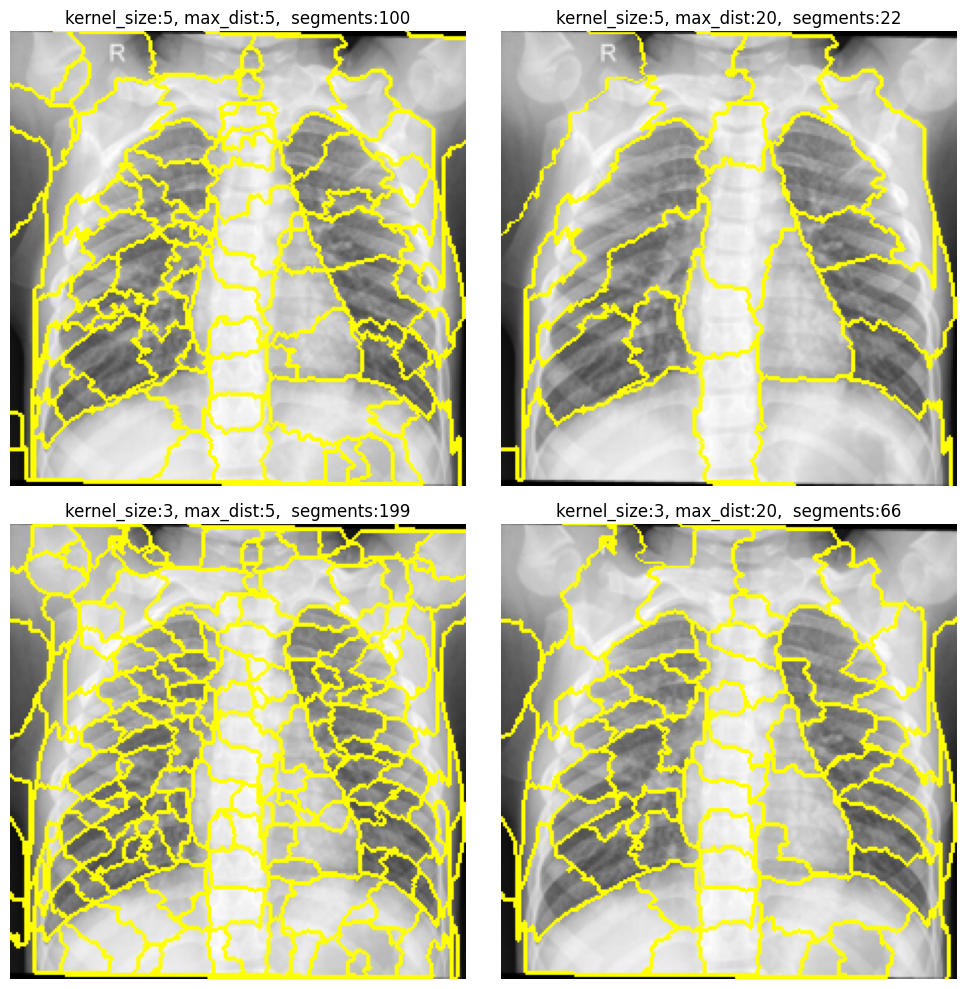

In [14]:
## display the impact of different segmentation parameters on the image.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots for displaying images
ax = ax.ravel()  # Flatten the grid to easily iterate over it

# Iterate over a list of segmentation parameters
for i, seg_args in enumerate([{'kernel_size':5, 'max_dist':5},
                           {'kernel_size':5, 'max_dist':20},
                           {'kernel_size':3, 'max_dist':5},
                           {'kernel_size':3, 'max_dist':20}]):

    # Apply the 'quickshift' segmentation algorithm to the test image with the current parameters
    segments = SegmentationAlgorithm('quickshift', **seg_args, ratio=0.2)(x_test[tn_i, ...])

    # Display the segmented image with boundaries marked
    ax[i].imshow(mark_boundaries(x_test[tn_i, ...], segments))
    # Set the title of the subplot to display the used parameters and the number of segments
    ax[i].set_title(f'kernel_size:{seg_args["kernel_size"]}, max_dist:{seg_args["max_dist"]},  segments:{len(np.unique(segments))}')
    ax[i].axis('off')  # Hide the axes of the subplot

plt.tight_layout()  # Adjust subplot parameters to have tight padding
plt.show()  # Display the figure with the subplots

In [ ]:
# The number of perturbed samples used during explanation is also a crucial step in explanation process with LIME

# The number of the perturbed samples determines the amount of data available for training the explainer

# Higher number of samples leads to a more robust and generalizable explainer

In [14]:
## define a function to display the LIME explanation.

def display_lime(image, samples, axs):
    explainer = lime_image.LimeImageExplainer()  # Initialize the LIME image explainer

    # Generate an explanation for the image
    # image: the image to explain
    # top_labels: the number of top labels to explain (top labels are the ones with the highest prediction probabilities)
    # batch_size: the batch size for the prediction. We use relatively large batch size to speed up the prediction
    # classifier_fn: is the function to use for prediction. We use the model's predict function
    # num_samples: the number of perturbations to perform. The higher the number, the larger the training data for the LIME explainer, the more robust the explanation
    # segmentation_fn: the segmentation function to use. We use the 'quickshift' algorithm with the specified parameters
    explanation = explainer.explain_instance(image=image, top_labels=1, batch_size=100,
                                             classifier_fn=lambda x: model.predict(x, verbose=0), num_samples=samples,
                                             segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=3, max_dist=20, ratio=0.2))

    # Get the image and mask for the top label
    # positive_only: whether to only show positive contributions
    # hide_rest: whether to hide the rest of the image
    _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False)

    # Generate a heatmap from the explanation
    heatmap = np.vectorize(dict(explanation.local_exp[explanation.top_labels[0]]).get)(explanation.segments)*np.abs(mask)

    axs.imshow(mark_boundaries(image, explanation.segments))  # Display the image with boundaries marked
    axs.imshow(heatmap, cmap = 'PiYG', vmin  = -np.abs(heatmap).max(), vmax = np.abs(heatmap).max(), alpha=0.5)  # Overlay the heatmap on the image

    axs.axis('off')  # Hide the axes

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

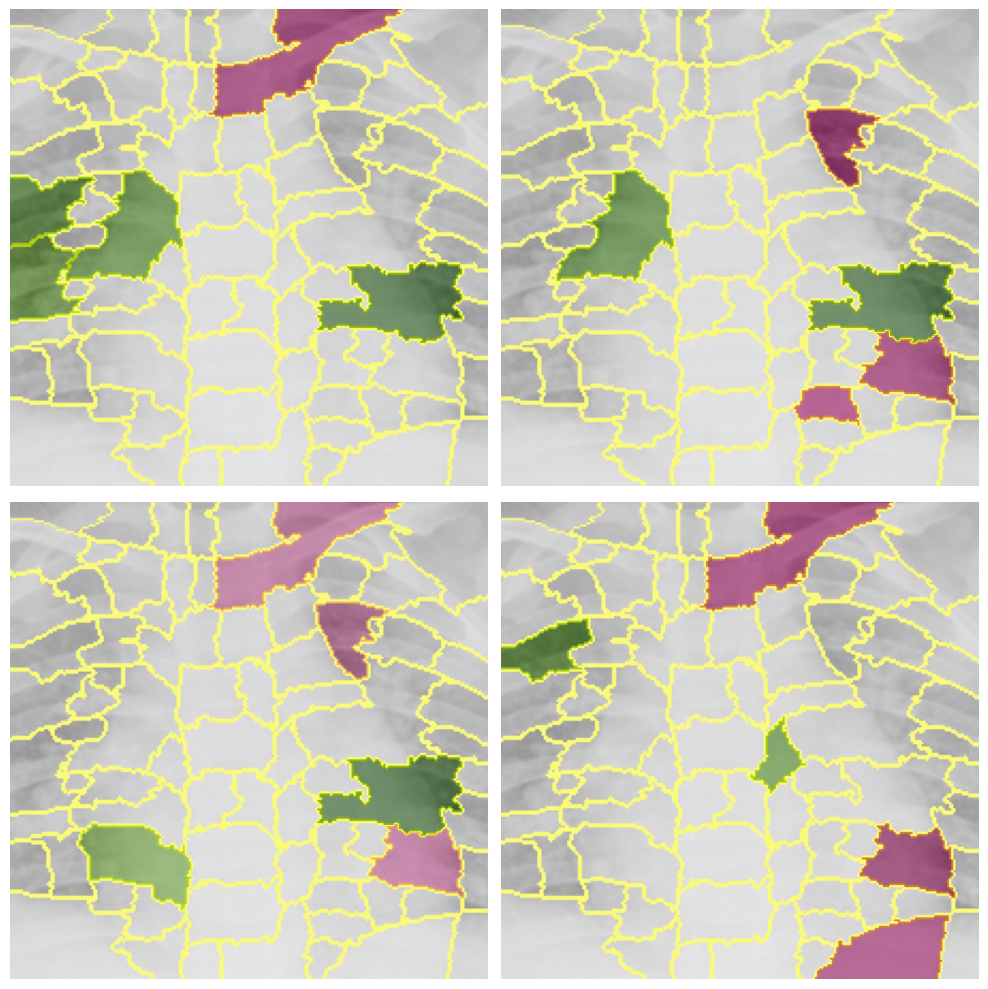

In [16]:
## display the impact of using small number of samples on the image explanation.

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over it

for i in range(4):
    display_lime(x_test[tp_i, ...], 100, axs[i])

plt.tight_layout()
plt.show()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

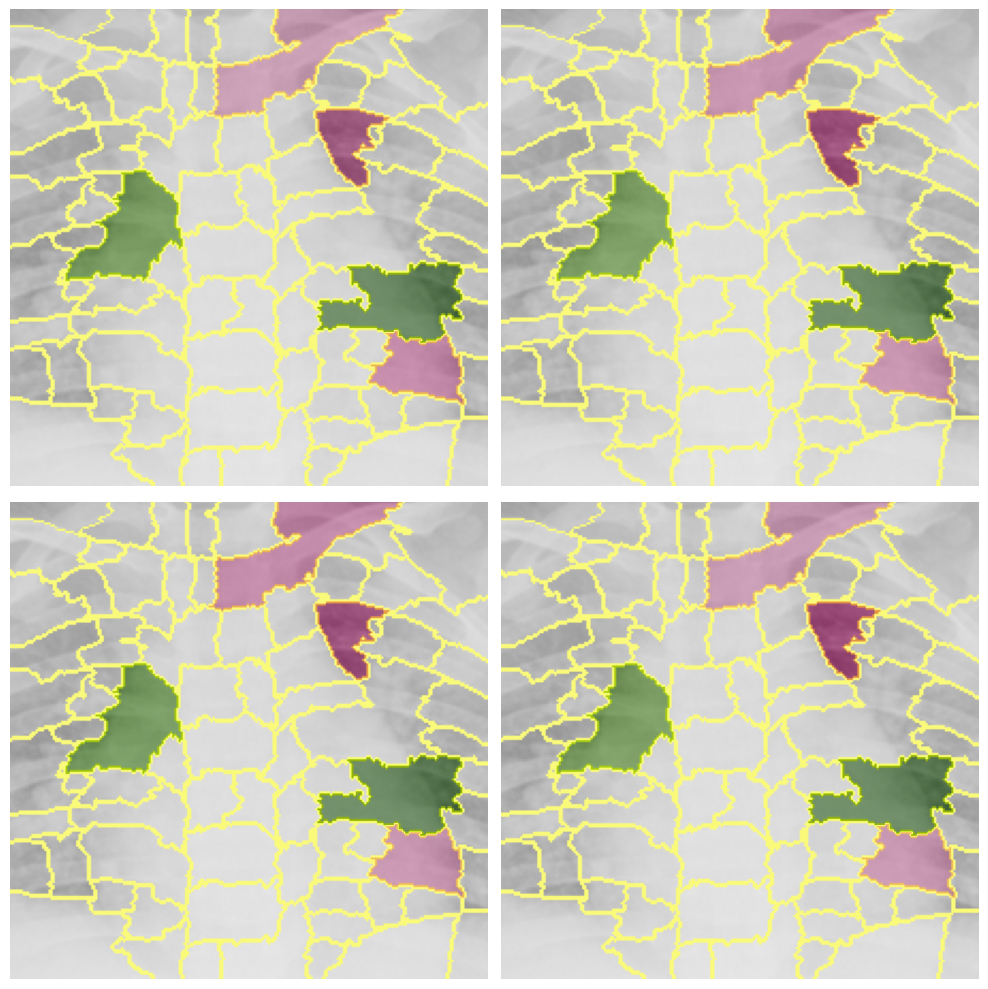

In [17]:
## display the impact of using large number of samples on the image explanation.

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over it

for i in range(4):
    display_lime(x_test[tp_i, ...], 6000, axs[i])

plt.tight_layout()
plt.show()

  0%|          | 0/6000 [00:00<?, ?it/s]

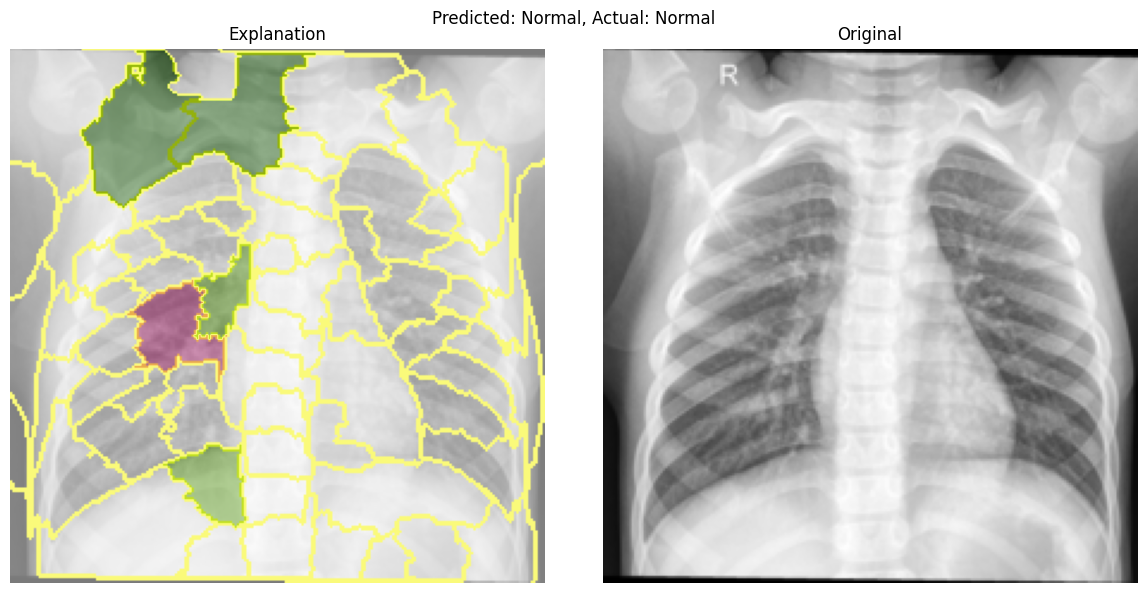

  0%|          | 0/6000 [00:00<?, ?it/s]

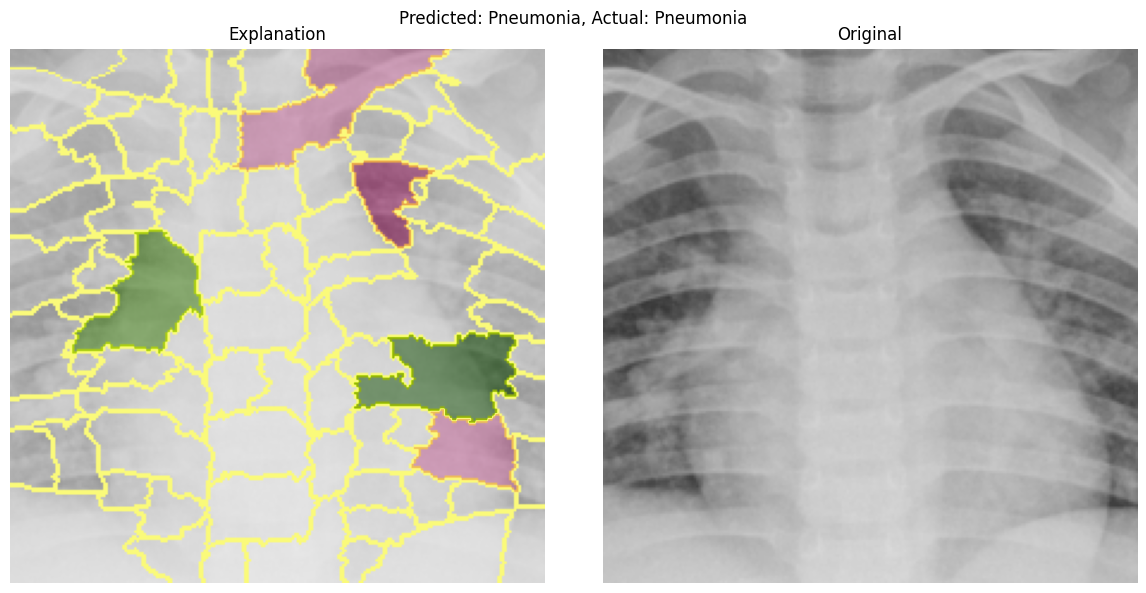

  0%|          | 0/6000 [00:00<?, ?it/s]

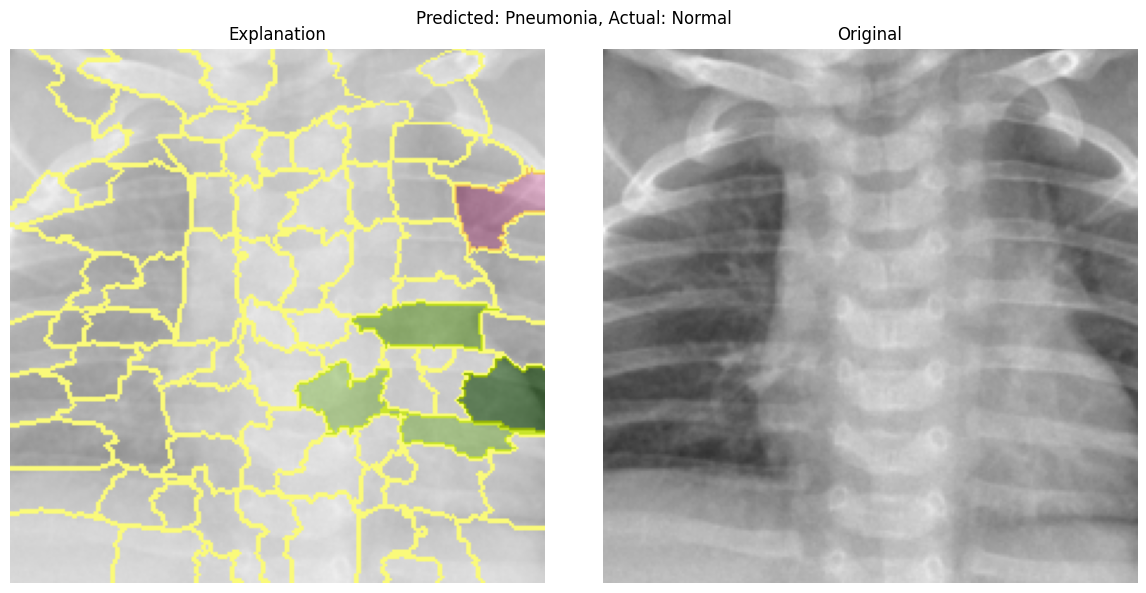

  0%|          | 0/6000 [00:00<?, ?it/s]

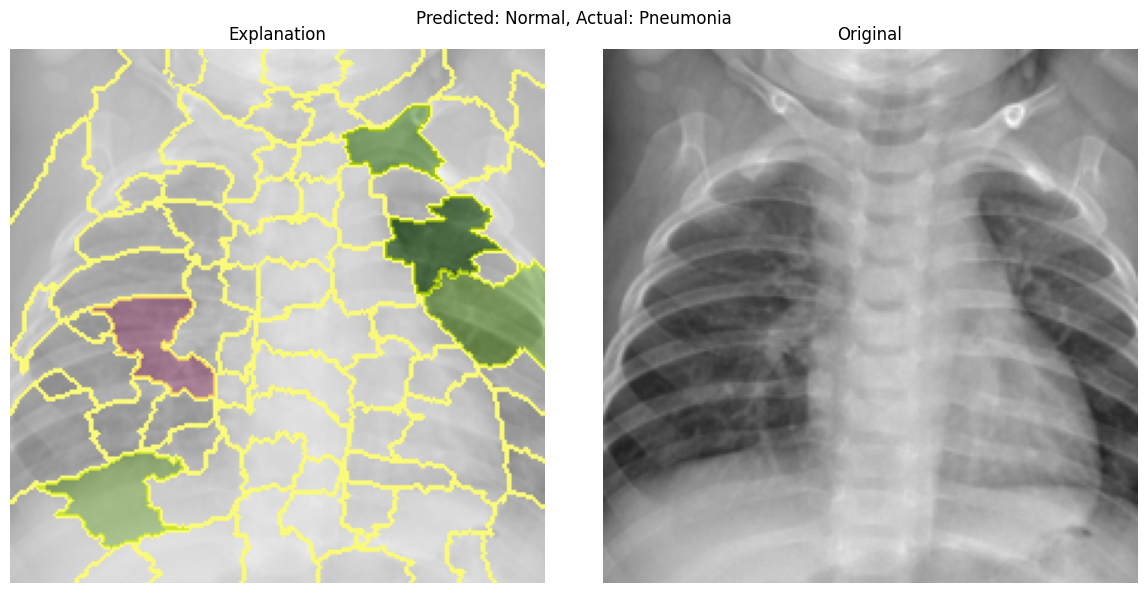

In [15]:
## display the LIME explanation for the four selected images.

# Iterate over the indices of the four selected images (true negative, true positive, false positive, false negative)
for i, image_i in enumerate([tn_i, tp_i, fp_i, fn_i]):
    
    preds = model.predict(x_test[image_i:image_i+1, ...], verbose=0)  # Predict the class of the current image using the model

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 1x2 grid of subplots for displaying the original image and its LIME explanation

    # Set the title of the figure to display the predicted and actual classes of the current image
    fig.suptitle(f"Predicted: {'Pneumonia' if preds[:, 1]>0.5 else 'Normal'}, Actual: {'Pneumonia' if y_test[image_i]>0.5 else 'Normal'}")

    display_lime(x_test[image_i, ...], 6000, axs[0])  # Display the LIME explanation of the current image on the first subplot
    
    axs[1].imshow(x_test[image_i, ...])  # Display the original image on the second subplot
    axs[1].axis('off')  # Hide the axes of the second subplot
    
    axs[0].set_title('Explanation')  # Set the title of the first subplot
    axs[1].set_title('Original')  # Set the title of the second subplot
    
    plt.tight_layout()  # Adjust subplot parameters to have tight padding
    plt.show()  # Display the figure with the subplots

In [16]:
## define a function to generate a Grad-CAM heatmap.

def make_gradcam_heatmap(img_array, model, pred_index=None):
    """
    This function generates a Grad-CAM heatmap for a given image.

    Parameters:
    img_array (np.array): the input image
    model (tf.keras.models.Model): the model
    pred_index (int): the index of the class to visualize

    Returns:
    heatmap (np.array): the generated heatmap
    
    """
    model.layers[-1].activation = None  # Remove the activation function from the last layer of the model. This allows us to get the logits instead of the probabilities and helps with the gradient calculation

    # Create a new model that outputs the last convolutional layer and the original output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('post_relu').output, model.output]
    )

    with tf.GradientTape() as tape:  # Start recording operations for automatic differentiation
        last_conv_layer_output, preds = grad_model(img_array)  # Get the output of the last convolutional layer and the original output
        if pred_index is None:  # If no prediction index is provided
            pred_index = tf.argmax(preds[0])  # Use the class with the highest prediction probability
        class_channel = preds[:, pred_index]  # Get the predictions for the selected class

    # Compute the gradient of the class output value with respect to the feature maps of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average the gradients spatially per channel
    last_conv_layer_output = last_conv_layer_output[0]  # Get the output of the last convolutional layer for the first (and only) image
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]  # Compute the dot product between the output and the pooled gradients
    heatmap = tf.squeeze(heatmap)  # Remove single-dimensional entries from the shape of the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize the heatmap
    return heatmap.numpy()  # Return the heatmap as a numpy array

def display_gradcam(img, heatmap, ax, alpha=0.4):
    """
    This function displays a Grad-CAM heatmap on an image.
    """
    ax.imshow(np.flipud(img))  # Display the image, flipping it vertically
    ax.axis('off')  # Hide the axes

    # Display the heatmap on top of the image, using the 'jet' colormap, bilinear interpolation, and the specified transparency
    i = ax.imshow(heatmap, alpha=alpha, cmap='jet', interpolation='bilinear', extent=(0, img.shape[1], 0, img.shape[0]))
    plt.colorbar(i, ax=ax)  # Add a colorbar for the heatmap

2024-05-26 20:21:50.043177: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 611.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-26 20:21:50.085998: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 611.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-26 20:21:50.339892: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 600.86MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-26 20:21:50.372760: W external/local_tsl/tsl/framewor

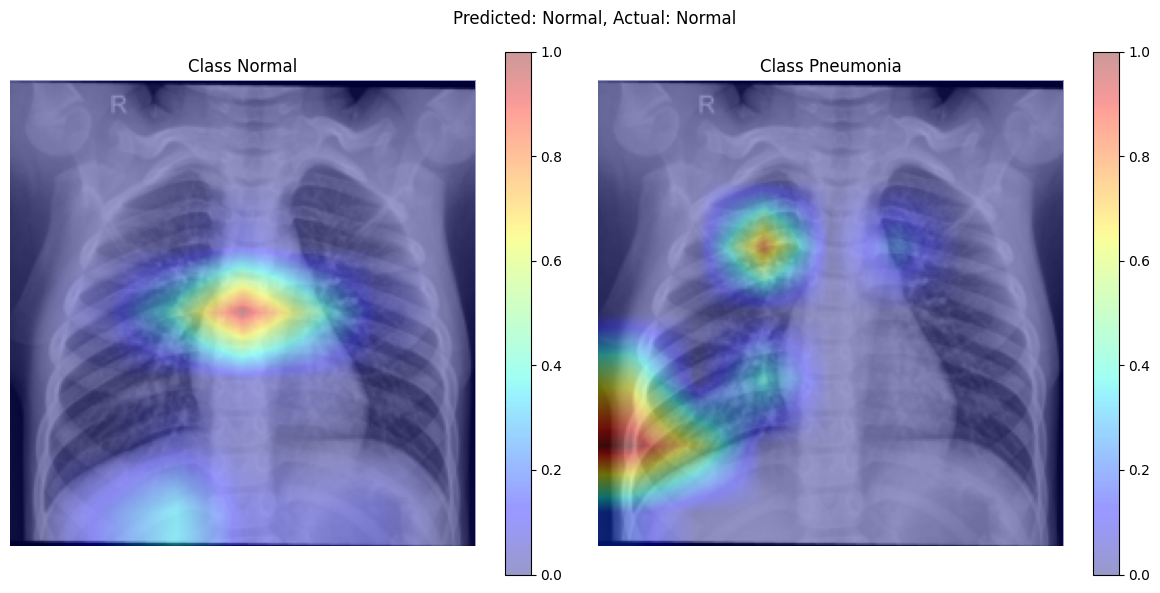

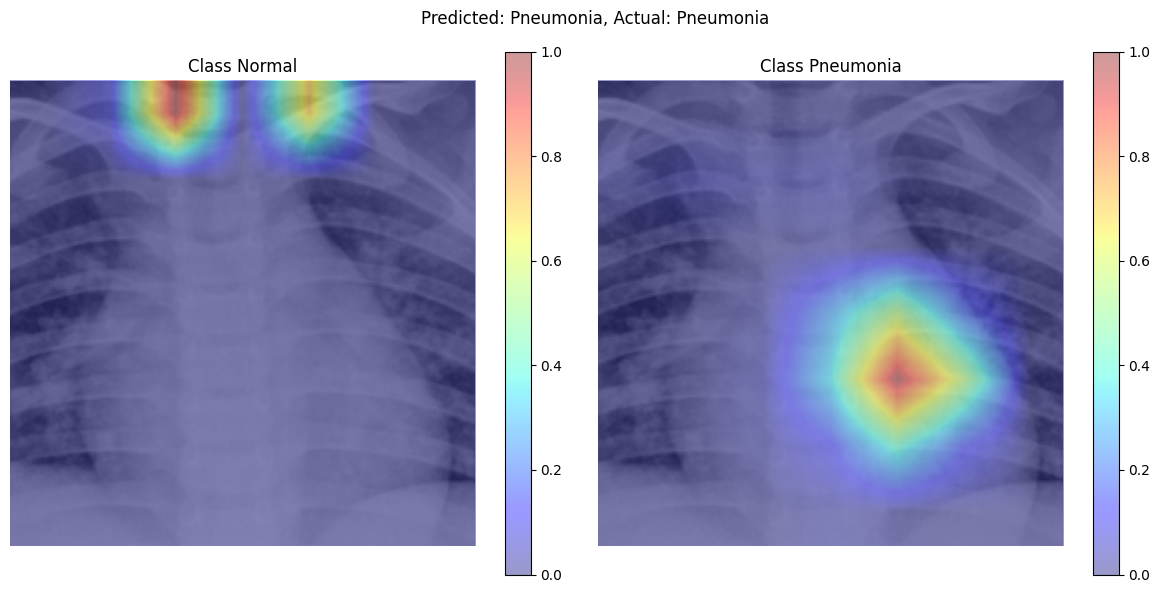

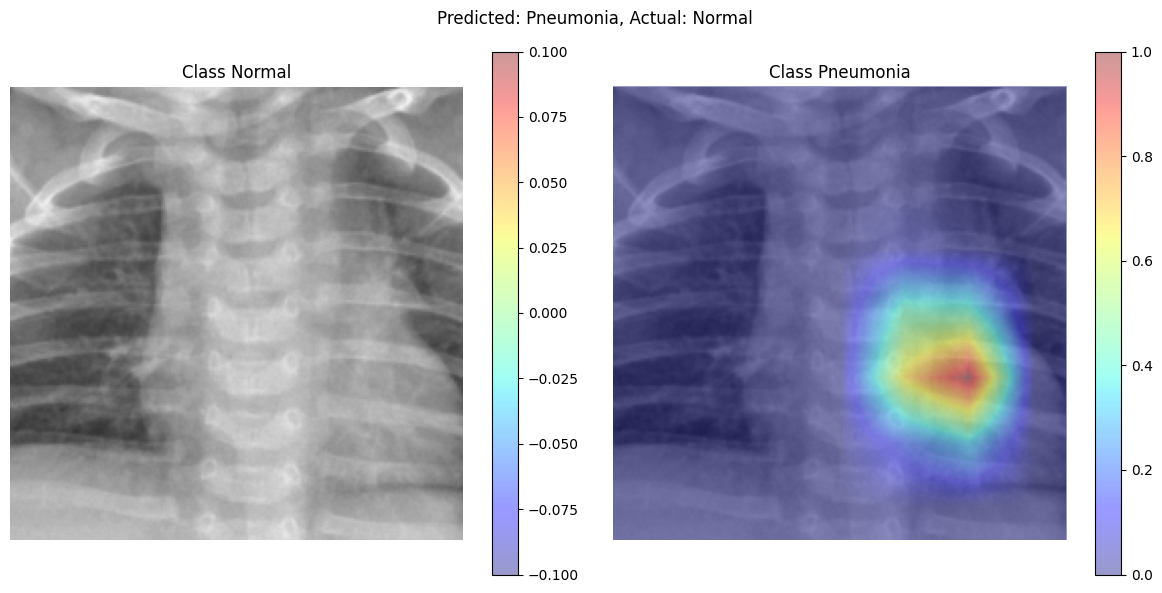

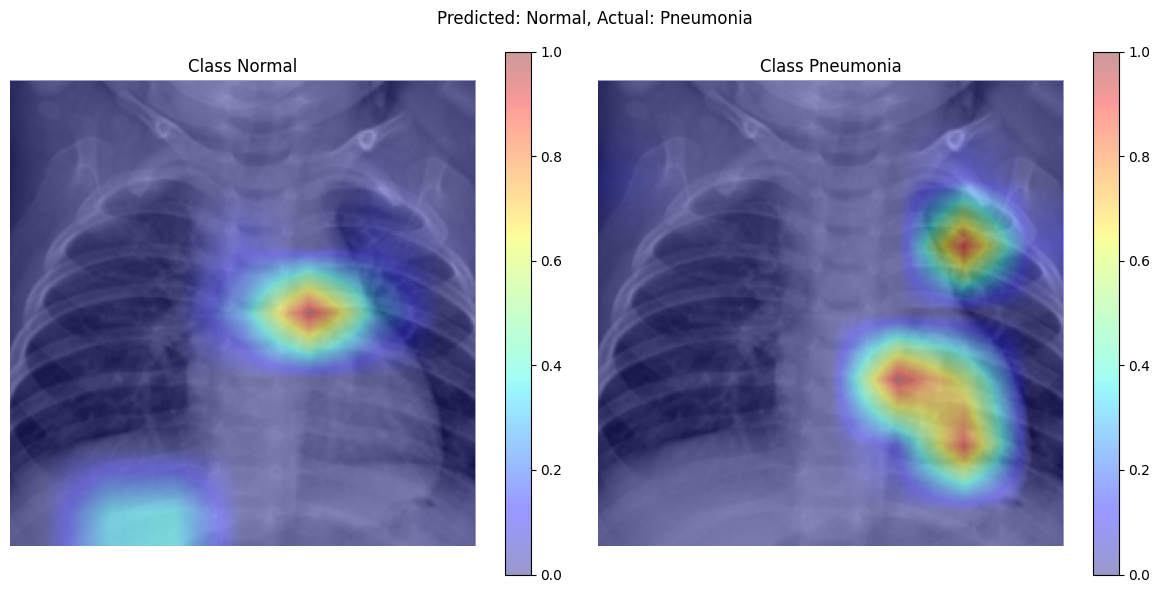

In [17]:
## display the Grad-CAM heatmap for the four selected images.

# Iterate over the indices of the four selected images (true negative, true positive, false positive, false negative)
for i, image_i in enumerate([tn_i, tp_i, fp_i, fn_i]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 1x2 grid of subplots for displaying the Grad-CAM heatmaps for the two classes
    
    preds = model.predict(x_test[image_i:image_i+1, ...], verbose=0)  # Predict the class of the current image using the model

    # Set the title of the figure to display the predicted and actual classes of the current image
    fig.suptitle(f"Predicted: {'Pneumonia' if preds[:, 1]>0.5 else 'Normal'}, Actual: {'Pneumonia' if y_test[image_i]>0.5 else 'Normal'}")
    
    # Generate a Grad-CAM heatmap for the current image for class Normal
    heatmap = make_gradcam_heatmap(x_test[image_i:image_i+1, ...], model, pred_index=0)
    # Display the Grad-CAM heatmap on the first subplot
    display_gradcam(x_test[image_i, ...], heatmap, axs[0])
    axs[0].set_title('Class Normal')  # Set the title of the first subplot

    # Generate a Grad-CAM heatmap for the current image for class Pneumonia
    heatmap = make_gradcam_heatmap(x_test[image_i:image_i+1, ...], model, pred_index=1)
    # Display the Grad-CAM heatmap on the second subplot
    display_gradcam(x_test[image_i, ...], heatmap, axs[1])
    axs[1].set_title('Class Pneumonia')  # Set the title of the second subplot

    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show()  # Display the figure with the subplots

# Summary

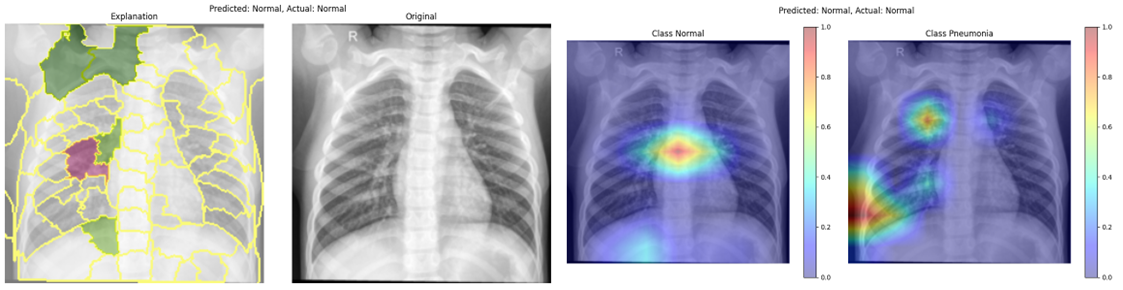

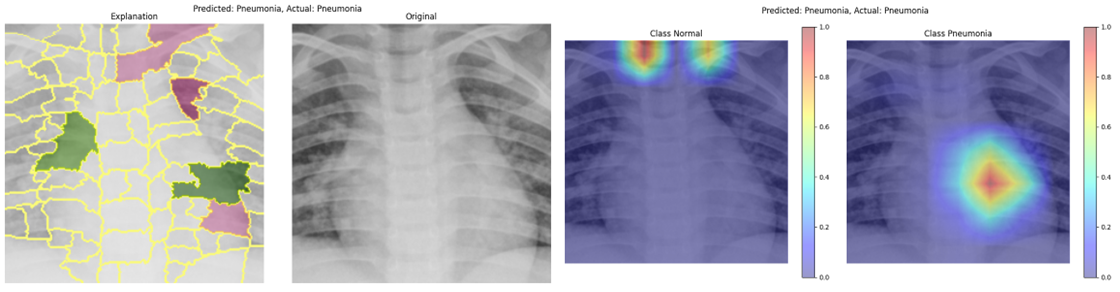

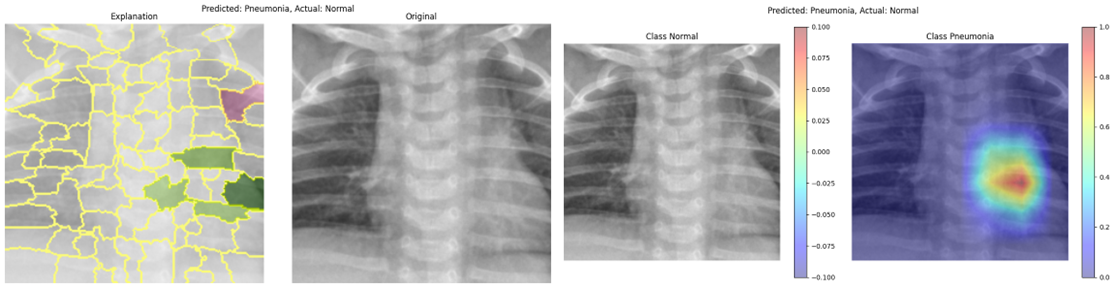

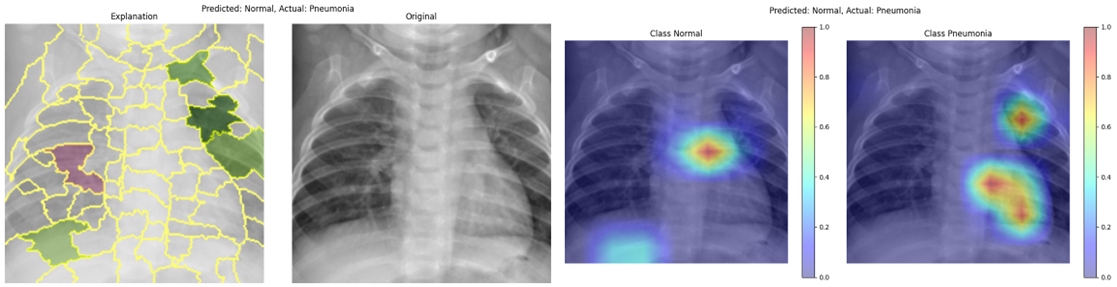

In [ ]:
# References

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. Yang, Jiancheng, et al. "MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification." Scientific Data, 2023.

Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.

Daniel S. Kermany, Michael Goldbaum, et al., "Identifying medical diagnoses and treatable diseases by image-based deep learning," Cell, vol. 172, no. 5, pp. 1122 – 1131.e9, 2018.